# Setup

**Workdir**

In [1]:
%cd /home/sg/hesssim

/home/sg/Seafile/ifes-hess-control/hesssim


**Import necessary stuff**

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import interpolate
from pprint import pprint

import hessemssim as hc

**Some preferences**

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
matplotlib.rcParams['figure.figsize'] = (10, 3)

# Test with Arbitrary Signal and Proportional Controller

**Generate a dummy signal**

In [4]:
np.random.seed(42)
xp = np.linspace(0, 1000, 20)
yp = -(np.random.random(np.size(xp))-0.2)
x = np.linspace(0, 1000, 1000)
y = interpolate.pchip_interpolate(xp, yp, x)
data = np.vstack([x, y])

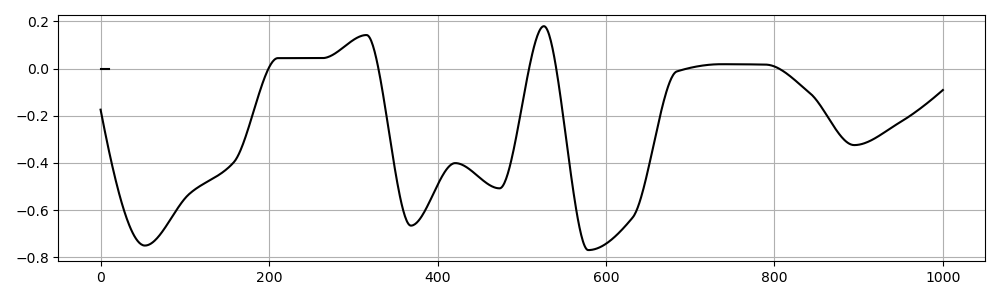

In [5]:
f, ax = plt.subplots()
ax.plot(x,y, color='k')
ax.plot([0, 10], [0, 0], color='k')
ax.grid(1)
f.tight_layout()

## With Proportional Controller

**Setup, Simulate, Plot System, Print Results**

/home/sg/hesssim/hessemssim/simulation.py:738: UserWarning: Stripping first value with timestamp = 0
  warn('Stripping first value with timestamp = 0')


Results(sim=SimulationResults(norm_mismatch=0.08998409311361086,
                              max_mismatch=0.3935655518321645,
                              n_mismatch=0.23923923923923918,
                              successful_fb_stepins=0.0,
                              failed_fb_stepins=0.0,
                              base_errors=0.0,
                              peak_errors=0.23923923923923918,
                              total_norm_dim=2.0231138309020325),
        base=StorageResults(cycles=0.7792287235909663,
                            stress=6.406959447291724,
                            high_power=0.055055055055055015,
                            limit_soc=0.060180180180180176,
                            enorm=0.7428850943209397,
                            pnorm=0.6494494118048951,
                            energy=200,
                            power=(-0.5, 0.5),
                            spec_power=0.0025),
        peak=StorageResults(cycles=1.00740682554372

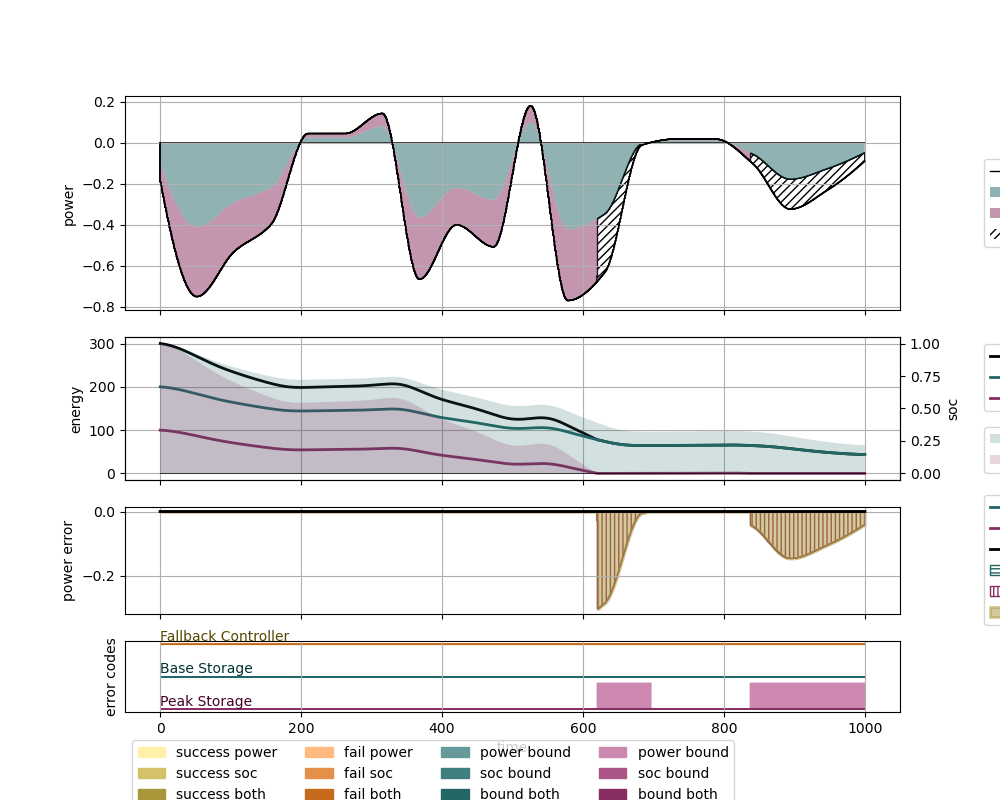

In [6]:
indata = hc.InputData(x, y)
base = hc.Storage(energy=200, power=(-0.5, 0.5), selfdischarge=0)
peak = hc.Storage(energy=100, power=(-0.8, 0.8), selfdischarge=0)
con = hc.ProportionalController(cut=0.55)
fb_con = hc.PassthroughFallbackController()
setup = hc.SimSetup(indata, base, peak, con, fb_con, sim_after_init=False)

# 1k ... 8.3ms
# 10k ... 85ms
# 100k ... 820ms
setup.simulate()

setup.plot()

pprint(setup.results)

## With filter-controller

Utilise PassthroughFallbackController. At the end of the simulation (~8.5s) base gets prematurely empty but the controller still assumes it can provide power. As a result, There is a mimatch between input and storage output (displayed hatched).

(<Figure size 1000x800 with 5 Axes>,
 array([<Axes: ylabel='power'>, <Axes: ylabel='energy'>,
        <Axes: ylabel='power error'>,
        <Axes: xlabel='time', ylabel='error codes'>], dtype=object))

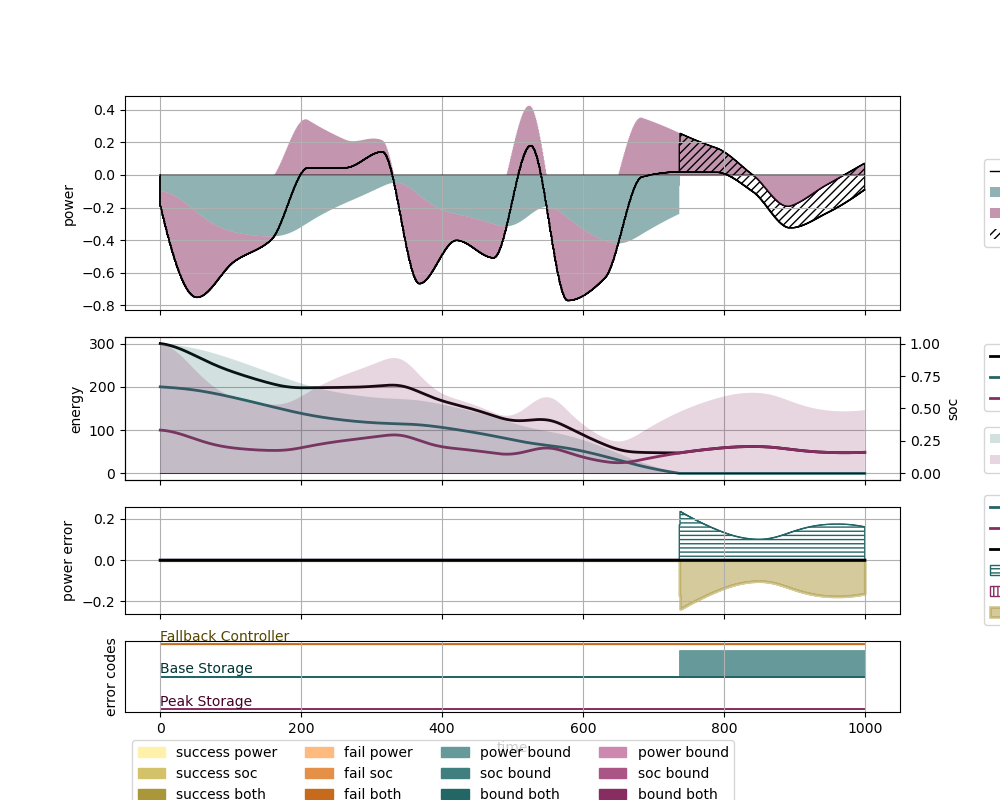

In [7]:
con_filter = hc.FilterController(fcut=0.001, finit=-0.18, ref=20, gain=0.001)
setup_f = hc.SimSetup(indata, base, peak, con_filter, fb_con, sim_after_init=False)
setup_f.simulate()
setup_f.plot()

## With filter-controller and real fallback-controller

... same example. This time, the real fallback controller is utilised. It can be seen at t ~ 8.5s that is correctly steps in and the input profile is handled completely.

(<Figure size 700x500 with 5 Axes>,
 array([<Axes: ylabel='power'>, <Axes: ylabel='energy'>,
        <Axes: ylabel='power error'>,
        <Axes: xlabel='time', ylabel='error codes'>], dtype=object))

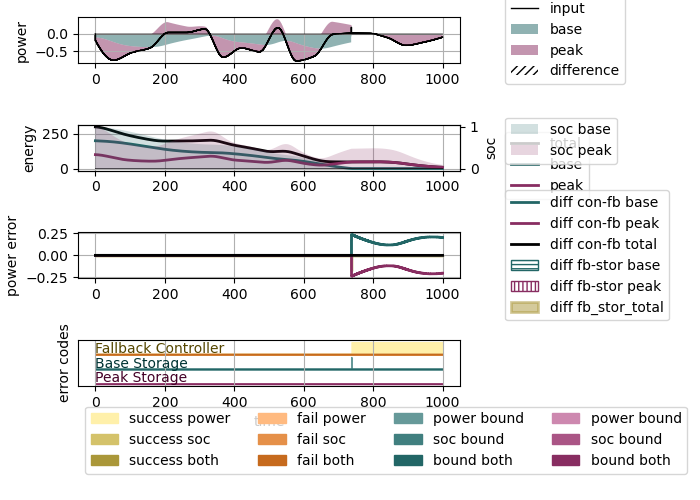

In [8]:
fb_real = hc.FallbackController()
setup_fb = hc.SimSetup(indata, base, peak, con_filter, fb_real, sim_after_init=False)
setup_fb.simulate()
fig, axs = plt.subplots(4,1, figsize=(7, 5))
setup_fb.plot(axs=axs, make_legend=True)

# Test with known Step/Stairs Signal and Deadzone Controller without Feedback

## 7 Timesteps

**Generate Signal**

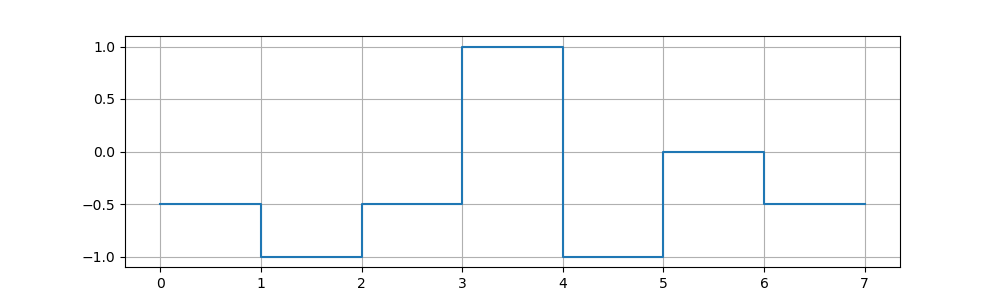

In [9]:
x2 = [0, 1, 2, 3, 4, 5, 6, 7]
y2 = [-0.5, -0.5, -1, -0.5, 1, -1, 0, -0.5]
stepfig, stepax = plt.subplots(1)
stepax.step(x2,y2)
stepax.grid('on')

**Setup, Simulate, Plot System, Print Results**

/home/sg/hesssim/hessemssim/simulation.py:738: UserWarning: Stripping first value with timestamp = 0
  warn('Stripping first value with timestamp = 0')


Results(sim=SimulationResults(norm_mismatch=0.0,
                              max_mismatch=0.0,
                              n_mismatch=0.0,
                              successful_fb_stepins=0.0,
                              failed_fb_stepins=0.0,
                              base_errors=0.0,
                              peak_errors=0.0,
                              total_norm_dim=1.4142135623730951),
        base=StorageResults(cycles=1.25,
                            stress=7.0,
                            high_power=0.8571428571428571,
                            limit_soc=0.11428571428571431,
                            enorm=0.8,
                            pnorm=0.5,
                            energy=2,
                            power=[-0.5, 0.5],
                            spec_power=0.25),
        peak=StorageResults(cycles=2.0,
                            stress=6.0,
                            high_power=0.42857142857142855,
                            limit_soc=0

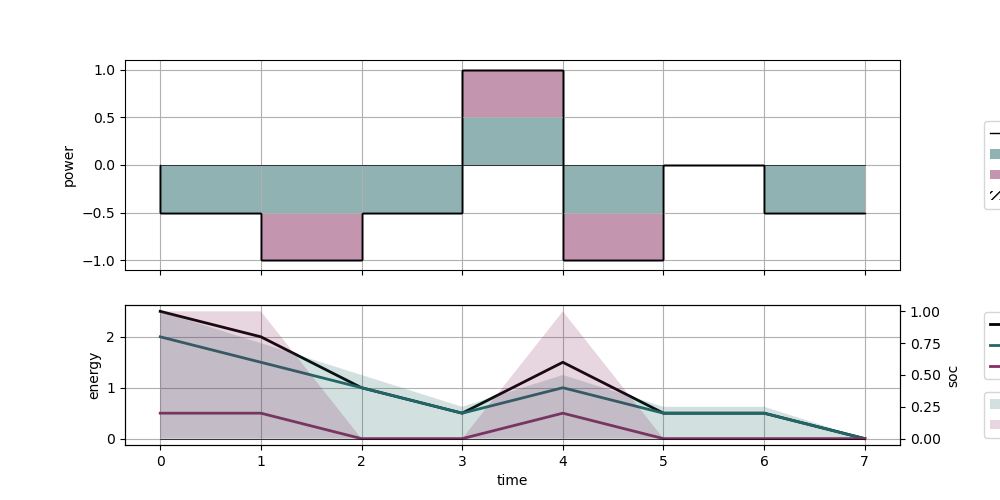

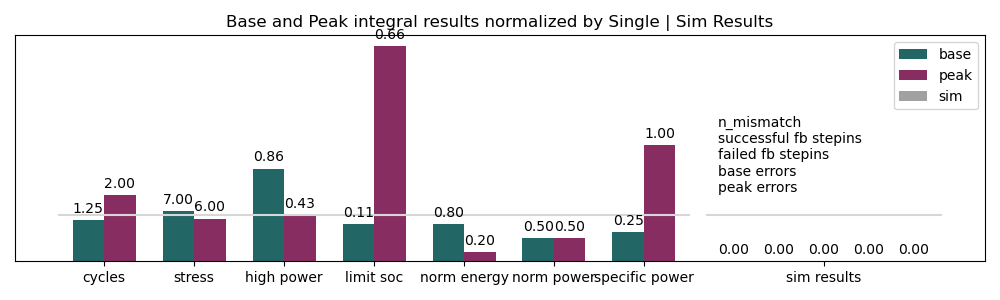

In [10]:
indata2 = hc.InputData(x2, y2)
base2 = hc.Storage(energy=2, power=0.5, selfdischarge=0, efficiency=1)
peak2 = hc.Storage(energy=0.5, power=0.5, selfdischarge=0, efficiency=1)
con2 = hc.DeadzoneController(gain=0)
fb_con2 = hc.PassthroughFallbackController()
setup2 = hc.SimSetup(indata2, base2, peak2, con2, fb_con2, sim_after_init=True)

setup2.plot()
setup2.plot_results()
pprint(setup2.results)

## Above example interpolated, must yield same results

In [11]:
x3 = np.linspace(0,7,71)
fint = interpolate.interp1d(x2, y2, kind='next')
y3 = fint(x3)

/home/sg/hesssim/hessemssim/simulation.py:738: UserWarning: Stripping first value with timestamp = 0
  warn('Stripping first value with timestamp = 0')


Results(sim=SimulationResults(norm_mismatch=0.0,
                              max_mismatch=0.0,
                              n_mismatch=0.0,
                              successful_fb_stepins=0.0,
                              failed_fb_stepins=0.0,
                              base_errors=0.014285714285714235,
                              peak_errors=0.0,
                              total_norm_dim=1.4142135623730951),
        base=StorageResults(cycles=1.2499999999999998,
                            stress=7.000000000000007,
                            high_power=0.8571428571428571,
                            limit_soc=0.11428571428571421,
                            enorm=0.8,
                            pnorm=0.5,
                            energy=2,
                            power=[-0.5, 0.5],
                            spec_power=0.25),
        peak=StorageResults(cycles=2.0,
                            stress=6.0,
                            high_power=0.4285714285714

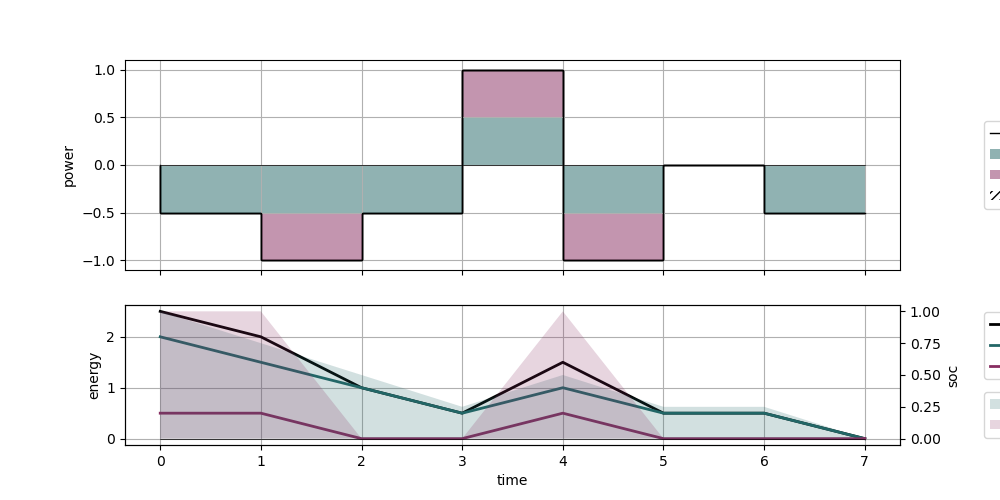

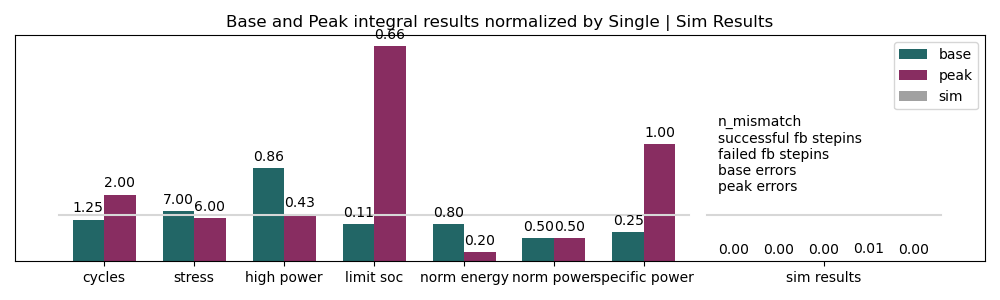

In [12]:
indata3 = hc.InputData(x3, y3)
setup3 = hc.SimSetup(indata3, base2, peak2, con2, fb_con2, sim_after_init=True)

setup3.plot()
setup3.plot_results()
pprint(setup3.results)